In [3]:
library(rlang)
library(monocle3)
library(shiny)
library(ggplot2)
library(dplyr)
library(garnett)
library(Matrix)
library(irlba)
library(ComplexHeatmap)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(circlize)

# loading modulated genes and cds

In [4]:
modulated_genes=readRDS('/home/jovyan/scripts/renal_covid_19/steroid_pipeline/trajectory_with_Rik_model_output/allCD14_wave2_steroid_2021_modulated_genes.rds')

In [5]:
cds = readRDS('/home/jovyan/scripts/renal_covid_19/steroid_pipeline/trajectory_with_Rik_model_output/allCD14_wave2_steroid_2021_cds.rds')

In [6]:
unique(cds$individual_id)

[1] C33  C101 C146 C138 C145 C147
Levels: C101 C138 C145 C146 C147 C33

# selected sig genes

In [7]:
genes <- row.names(subset(modulated_genes, q_value <0.05 & morans_I > 0.1 ))#& morans_I > 0.2
length(genes)

[1] 282

In [8]:
# remove mito and ribo genes
genes <-genes[!grepl(paste0('^RPL', collapse = "|"), genes)]
genes <-genes[!grepl(paste0('^RPS', collapse = "|"), genes)]
genes <-genes[!grepl(paste0('^MT-', collapse = "|"), genes)]

length(genes)

[1] 203

# get count matrix for sig genes in pseudo time order

In [9]:
pt.matrix <- as.matrix(cds@assays@data$counts[match(genes,rownames(rowData(cds))),order(cds$pseudotime_GPLVM)]) # order by pseudotime_GPLVM

In [10]:
cellname <-colnames(pt.matrix)

# smoothening

In [11]:
pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=3)$y}))
pt.matrix <- t(apply(pt.matrix,1,function(x){(x-mean(x))/sd(x)}))

In [12]:
rownames(pt.matrix) <- genes;

In [13]:
colnames(pt.matrix) <- cellname;

# getting cluster bars

In [14]:
unique(cds$WHO_temp_severity) #checking clusters

[1] critical nan      mild     severe   moderate
Levels: critical mild moderate nan severe

In [15]:
unique(cds$case_control)

[1] POSITIVE RECOVERY
Levels: POSITIVE RECOVERY

In [17]:
cds$WHO_temp_severity_correct <- factor(cds$WHO_temp_severity, levels = c('nan','mild', 'moderate','severe','critical'), labels = c('recovery','mild','moderate','severe','critical'))

In [18]:
unique(cds$WHO_temp_severity_correct)

[1] critical recovery mild     severe   moderate
Levels: recovery mild moderate severe critical

In [19]:
pseudo_time <-pseudotime(cds)
pseudo_time <- as.data.frame(pseudo_time)
#print (head(pseudo_time))

                                                 pseudo_time
UK-CIC10690366+UK-CIC10690558_AACTTTCCAAGTCATC-1   10.308260
UK-CIC10690366+UK-CIC10690558_TATTACCAGAGTAATC-1   11.813688
UK-CIC10690367+UK-CIC10690559_TTGGCAAGTATATGGA-1   14.100141
UK-CIC10690325+UK-CIC10690517_GCGCGATCACCCAGTG-1   14.992196
UK-CIC10690319+UK-CIC10690511_GCTTGAAAGATCCCAT-1   11.940785
UK-CIC10690373+UK-CIC10690565_CTCGTCACAGCGTCCA-1    9.990809


In [20]:
day_from_steroid <-(colData(cds)[, "days_from_steroid"])
day_from_steroid <- as.data.frame(day_from_steroid)
#tail(day_from_steroid)

In [21]:
pseudotime_GPLVM <-(colData(cds)[, "pseudotime_GPLVM"])
pseudotime_GPLVM <- as.data.frame(pseudotime_GPLVM)
#tail(pseudotime_GPLVM)

In [22]:
sev <-(colData(cds)[, "WHO_temp_severity_correct"])
df_sev <- as.data.frame(sev)
#tail(df_sev)

In [23]:
case_control <-(colData(cds)[, "case_control"])
case_control <- as.data.frame(case_control)
#tail(case_control)

In [24]:
time_from_first_symptoms<-(colData(cds)[, "time_from_first_symptoms"])
time_from_first_symptoms <- as.data.frame(time_from_first_symptoms)
#tail(time_from_first_symptoms)

In [25]:
time_from_pos_swab<-(colData(cds)[, "time_from_positive_swab"])
time_from_pos_swab <- as.data.frame(time_from_pos_swab)
#tail(time_from_pos_swab)

In [26]:
time_from_inf <-(colData(cds)[, "time_from_infection"])
time_from_inf <- as.data.frame(time_from_inf)
#tail(time_from_inf)

In [27]:
top_anno <- cbind(case_control,time_from_inf,pseudotime_GPLVM,df_sev,pseudo_time,time_from_pos_swab,time_from_first_symptoms,day_from_steroid)

In [28]:
top_anno <-top_anno[order(top_anno$pseudotime_GPLVM),]
head(top_anno)

,case_control,time_from_inf,pseudotime_GPLVM,sev,pseudo_time,time_from_pos_swab,time_from_first_symptoms,day_from_steroid
,<fct>,<int>,<dbl>,<fct>,<dbl>,<int>,<int>,<int>
UK-CIC10690338+UK-CIC10690530_ACACCGGCAAGCGAGT-1,POSITIVE,2,-0.25155908,mild,0.1202932,2,0,-3
UK-CIC10690356+UK-CIC10690548_TGCGGGTTCAAGATCC-1,POSITIVE,2,-0.17931786,mild,1.4055118,2,0,-6
UK-CIC10690340+UK-CIC10690532_GTGCAGCGTTATCCGA-1,POSITIVE,2,-0.14722562,mild,1.6164945,2,0,-3
UK-CIC10690337+UK-CIC10690529_AACACGTTCGTTTGCC-1,POSITIVE,2,-0.11153327,mild,4.2132714,2,0,-3
UK-CIC10690335+UK-CIC10690527_TGATTTCCAAGGACTG-1,POSITIVE,2,-0.09948054,mild,6.2093626,2,2,2
UK-CIC10690355+UK-CIC10690547_CGATGGCCATGCGCAC-1,POSITIVE,2,-0.09696293,mild,7.2415613,2,0,-6


# get colann and plot heatmap

In [30]:
library(ComplexHeatmap)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(circlize)

ann <- data.frame(top_anno$sev,top_anno$pseudotime_GPLVM, top_anno$case_control,top_anno$time_from_inf,top_anno$pseudo_time,top_anno$time_from_pos_swab,top_anno$time_from_first_symptoms,top_anno$day_from_steroid)#top_anno$day_from_steroid,
colnames(ann) <- c('sev','pseudotime_GPLVM', 'case_control','time_from_inf','pseudotime','time_from_pos_swab','time_from_first_symptoms','day_from_steroid')#,
colours <- list('sev' = c('recovery'='green','mild' = 'gold','moderate' ='red','severe' = 'royalblue','critical'='black'),            
  'case_control' = c('POSITIVE' = 'limegreen','RECOVERY'='purple'),#, 'RECOVERY' = 'gold'
    'time_from_inf' = colorRamp2(c(min(top_anno$time_from_inf), max(top_anno$time_from_inf)), c("white", "blue")),
                'day_from_steroid' = colorRamp2(c(min(top_anno$day_from_steroid), max(top_anno$day_from_steroid)), c("white", "red")),
                'time_from_pos_swab' = colorRamp2(c(min(top_anno$time_from_pos_swab), max(top_anno$time_from_pos_swab)), c("white", "green")),
                'time_from_first_symptoms' = colorRamp2(c(min(top_anno$time_from_first_symptoms), max(top_anno$time_from_first_symptoms)), c("white", "black"))
        )
colAnn <- HeatmapAnnotation(df = ann,
  which = 'col',
  col = colours,
  annotation_width = unit(c(1, 4), 'cm'),
  gap = unit(1, 'mm'))

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  3

png 
  2

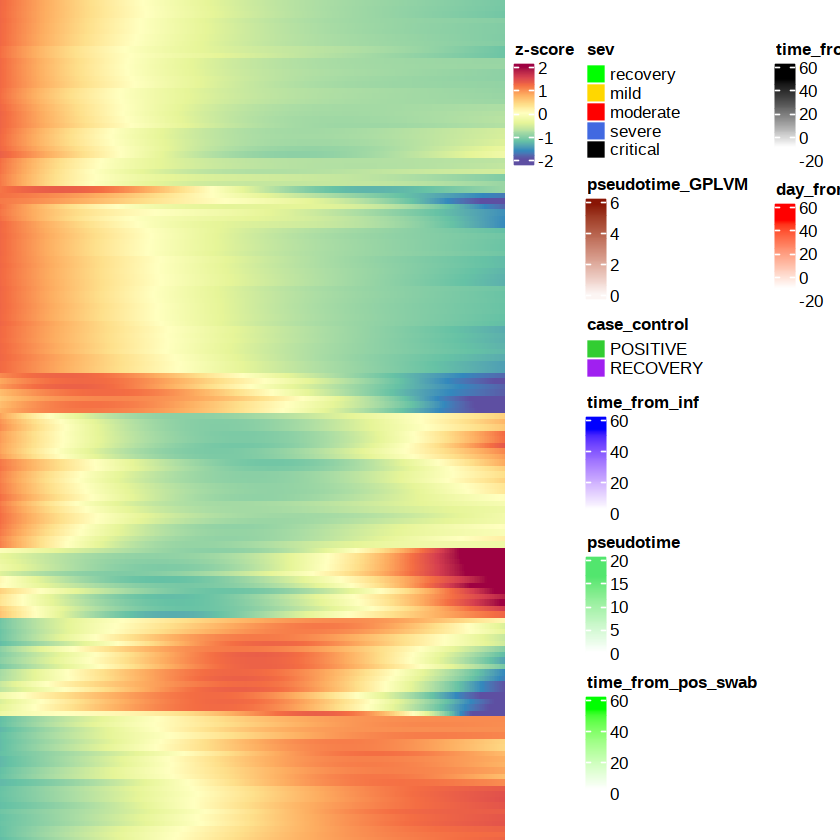

In [39]:

hthc <- ComplexHeatmap::Heatmap(
pt.matrix,
  name                         = "z-score",
  col                          = colorRamp2(seq(from=-2,to=2,length=11),rev(brewer.pal(11, "Spectral"))),
  show_row_names               = FALSE,
  show_column_names            = FALSE,
  row_names_gp                 = gpar(fontsize = 12),
  clustering_method_rows = "ward.D2",
  clustering_method_columns = "ward.D2",
  row_title_rot                = 0,
  cluster_rows                 = TRUE,
  cluster_row_slices           = FALSE,
  cluster_columns              = FALSE,
  width = unit(12.8, "cm"), height = unit(25, "cm"),
  top_annotation = colAnn)
 # bottom_annotation = ba)
print(hthc)


file =paste0("/home/jovyan/scripts/renal_covid_19/steroid_pipeline/trajectory_with_Rik_model_output/")
dev.copy(png,filename=paste0(file,'allCD14_wave2_steroid_2021_norow1.png'),width=1200, height=2500);
dev.off ();